In [1]:
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Regularized Word Embeddings in Text Classification and in Ad-hoc IR
## 4. Document Representations

We consider three document representations:

- Vector Space Model (VSM)
- Soft Vector Space Model (Soft VSM)
- Latent Semantic Indexing (LSI)

We consider four term weighting schemes:

- Binary
- Bag of Words (BOW)
- TF-IDF
- Okapi BM25

An we also consider three similarities:

- Inner Product (IP)
- Word Mover's Distance (WMD)
- Neural Translation Language Model (NTLM)

## 6. Evaluation

Not all combinations of document representations, term weighting schemes, and similarities are evaluated:

| ↓ Weights, Space and similarity → | VSM IP | VSM WMD | VSM NTLM | Soft VSM IP | LSI IP |
|--|--|--|--|--|--|
| Binary | ❌ | ❌ | ❌ | ✅<sup>2, 3</sup>  | ❌ |
| BOW | ✅ | ✅<sup>3</sup> | ✅<sup>1, 3</sup> | ❌ | ❌ |
| TF-IDF | ✅ | ❌ | ❌ | ✅<sup>3</sup> | ✅ |
| Okapi BM25 | ✅ | ❌ | ❌ | ❌ | ❌ |

<sup>1</sup> We use the non-normalized BOW.  
<sup>2</sup> We use the dense soft VSM.  
<sup>3</sup> Not yet implemented.

In [2]:
configurations = [
    ('vsm', 'bow', 'inner_product', 32),
    ('vsm', 'tfidf', 'inner_product', 32),
    ('vsm', 'bm25', 'inner_product', 32),
    ('lsi', 'tfidf', 'inner_product', 32),
]

There are several parameters that are tuned by grid search.

- Soft VSM:
    - `dense`${}\in\{$ `True`, `False` $\}$
    - `symmetric`${}\in\{$ `True`, `False` $\}$ (only relevant when `dense` is `False`)
    - `positive_definite`${}\in\{$ `True`, `False` $\}$ (only relevant when `dense` is `False`)
    - `tfidf`${}\in\{$ `<TfidfModel>`, `None` $\}$ (only relevant when `dense` is `False`)
    - `nonzero_limit`${}\in\{100, 200, \ldots, 600\}$
- TFIDF:
    - `slope`${}\in\{0.0, 0.1, \ldots, 1.0\}$
- Okapi BM25:
    - $k_1\in\{1.2, 1.3, \ldots, 2.0\}$

   
### 6.1 Datasets


In [3]:
from common import ClassificationResult

results = dict()


def load_results(name, dataset_loader):
    """Loads classification results for a given dataset.
    
    Parameters
    ----------
    name : str
        The name of a dataset.
    dataset_loader : callable
        Loads training, validation, and test sets from the dataset.
    """

    results[name] = dict()
    datasets = None
    for configuration in configurations:
        basename = '{}-{}'.format(name, '-'.join(map(str, configuration)))
        try:
            results[name][configuration] = ClassificationResult.from_file(basename)
        except IOError:
            if datasets is None:
                datasets = dataset_loader()
            train, validation, test = datasets
            result = train.classify(validation, test, *configuration)
            result.to_file(basename)
            results[name][configuration] = result

2019-01-30 22:38:07,147 : INFO : 'pattern' package not found; tag filters are not available for English



For classification, we use the following datasets:

- [20 Newsgroups][] (1995, 14M, 18.83k documents, *free*)

 [20 Newsgroups]: http://qwone.com/~jason/20Newsgroups/ (Home Page for 20 Newsgroups Data Set)

In [4]:
from common import load_newsgroups

load_results('newsgroups', load_newsgroups)

2019-01-30 22:38:07,514 : INFO : Loading a classification result from file results/classification-newsgroups-vsm-bow-inner_product-32.pkl.xz.
2019-01-30 22:38:07,520 : INFO : Loading a classification result from file results/classification-newsgroups-vsm-tfidf-inner_product-32.pkl.xz.
2019-01-30 22:38:07,521 : INFO : Loading a classification result from file results/classification-newsgroups-vsm-bm25-inner_product-32.pkl.xz.
2019-01-30 22:38:07,526 : INFO : Loading a classification result from file results/classification-newsgroups-lsi-tfidf-inner_product-32.pkl.xz.



- [AMAZON][] (2015, 20G, 142.8m documents, *free*)
    - For computational efficiency, we subsample the dataset using four of the 24 product categories.
    - For computational efficiency, we subsample the dataset using only 1 out of every 100 review texts.

 [AMAZON]: http://jmcauley.ucsd.edu/data/amazon/ (Amazon review data)


In [5]:
from common import load_amazon

# load_results('bbc', load_bbc)  # Not yet computed.


- [BBC] (2005, 864K, 2.23k documents, *free*)

 [BBC]: http://mlg.ucd.ie/datasets/bbc.html (Insight - BBC Datasets)

In [6]:
from common import load_bbc

# load_results('bbc', load_bbc)  # Not yet computed.


- [BBCSport][BBC] (2005, 255K, 737 documents, *free*)

 [BBC]: http://mlg.ucd.ie/datasets/bbc.html (Insight - BBC Datasets)

In [7]:
from common import load_bbcsport

# load_results('bbcsport', load_bbcsport)  # Not yet computed.


- [OHSUMED][] (1994, 24M, 50.22k documents, *free*)

 [OHSUMED]: http://disi.unitn.it/moschitti/corpora.htm (Donwloadable Corpora)


In [8]:
from common import load_ohsumed

# load_results('bbcsport', load_ohsumed)  # Not yet computed.


- [Reuters-21578][] (1987, 8.2M, 215.78k documents, *free*)

 [Reuters-21578]: http://www.daviddlewis.com/resources/testcollections/reuters21578/ (Reuters-21578 Text Categorization Test Collection)

In [9]:
from common import load_reuters

# load_results('reuters', load_reuters)  # Not yet computed.

- [TWITTER][] (2011, 160K, 6.4k documents, *free*)

 [TWITTER]: https://web.archive.org/web/20180328044709/www.sananalytics.com/lab/twitter-sentiment/ (Sanders Analytics - Twitter Sentiment Corpus)

In [10]:
from common import load_twitter

# load_results('twitter', load_twitter)  # Not yet computed.


### 6.3 Classification

We compare the individual document representations, term weighing schemes, and similarities using $k$NN on standard datasets. In addition to the above parameters, we also tune $k\in\{1,2,\ldots,19\}$.

## 7. Results

TODO (Michal Štefánik).  
Useful links:

- [Monochrome (Black & white) plots in matplotlib](http://olsgaard.dk/monochrome-black-white-plots-in-matplotlib.html)
- [Add confidence interval on barplot](https://python-graph-gallery.com/8-add-confidence-interval-on-barplot/)

In [11]:
results['newsgroups']

{('vsm',
  'bow',
  'inner_product',
  32): <ClassificationResult, accuracy: 42.19%, params: {'k': 1, 'measure': 'inner_product', 'weights': 'bow', 'num_bits': 32, 'space': 'vsm'}>,
 ('vsm',
  'tfidf',
  'inner_product',
  32): <ClassificationResult, accuracy: 67.06%, params: {'num_bits': 32, 'k': 17, 'measure': 'inner_product', 'weights': 'tfidf', 'slope': 1.0, 'space': 'vsm'}>,
 ('vsm',
  'bm25',
  'inner_product',
  32): <ClassificationResult, accuracy: 61.18%, params: {'num_bits': 32, 'k': 1, 'measure': 'inner_product', 'weights': 'bm25', 'k1': 2.0, 'space': 'vsm'}>,
 ('lsi',
  'tfidf',
  'inner_product',
  32): <ClassificationResult, accuracy: 63.99%, params: {'num_bits': 32, 'k': 1, 'measure': 'inner_product', 'weights': 'tfidf', 'slope': 1.0, 'space': 'lsi'}>}

In [12]:
help(results['newsgroups'][('vsm', 'bow', 'inner_product', 32)].accuracy)

Help on method accuracy in module common:

accuracy(significance_level=0.05) method of common.ClassificationResult instance
    Returns pointwise and interval estimates for the accuracy.
    
    Parameters
    ----------
    significance_level : scalar
        The likelihood that the actual accuracy falls into the
        confidence interval.
    
    Returns
    -------
    pointwise_estimate : scalar
        An unbiased pointwise estimate of the expected value of
        the accuracy.
    lower_bound : scalar
        The lower bound of the confidence interval for the accuracy.
    upper_bound : scalar
        The upper bound of the confidence interval for the accuracy.



In [13]:
results['newsgroups'][('vsm', 'tfidf', 'inner_product', 32)].accuracy()

(0.6706054168879447, 0.6599063054175914, 0.6811305932543966)

In [68]:
results['newsgroups2'] = results['newsgroups']

In [44]:
styles = ({'hatch': '///', 'color': 'w', 'zorder': 10},
          {'hatch': '--', 'color': 'w', 'zorder': 10},
          {'hatch': '...', 'color': 'w', 'zorder': 10},
          {'hatch': 'xxx', 'color': 'w', 'zorder': 10})

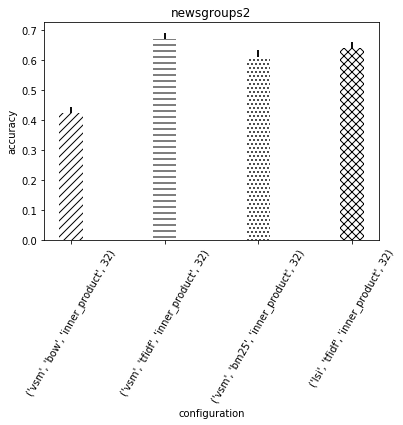

In [104]:
# TODO: segmentation by groups needs to be done as in
# https://stackoverflow.com/questions/14270391/python-matplotlib-multiple-bars

import matplotlib.pyplot as plt
import numpy as np

for x_i, dataset in enumerate(results.keys()):
    ax = plt.subplot(111)

    x = [str(k) for k in results[dataset]]
    y = [v.accuracy()[0] for v in results[dataset].values()]
    yerr1 = [v.accuracy()[1] for v in results[dataset].values()]
    yerr2 = [v.accuracy()[2] for v in results[dataset].values()]
    
    width = 0.25 # the width of the bars 
    ind = np.arange(len(y))  # the x locations for the groups
    for i, _ in enumerate(ind):
        plt.bar(ind[i], y[i], width, **styles[i], align='center',
                yerr=abs(yerr1[i] - yerr2[i]))
        ax.set_xticks(ind)
        ax.set_xticklabels(x, minor=False, rotation=60)
    plt.title(dataset)
    plt.ylabel('accuracy')
    plt.xlabel('configuration')
fig.set_size_inches(10, 5)
